In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.layers import concatenate

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
     # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [4]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
 filepath = prefix + group + '/Inertial Signals/'
 # load all 9 files as a single array
 filenames = list()
 # total acceleration
 filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
 # body acceleration
 filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
 # body gyroscope
 filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
 # load input data
 X = load_group(filenames, filepath)
 # load class output
 y = load_file(prefix + group + '/y_'+group+'.txt')
 return X, y

In [5]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    print('load_dataset append_before = {}'.format(prefix))
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    print('---------before(y)----------')
    print(trainy.shape)
    trainy = trainy - 1
    testy = testy - 1
    print('---------after(y)-----------')
    print(trainy.shape)
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [6]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
 verbose, epochs, batch_size = 0, 10, 32
 n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
 model = Sequential()
 model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
 model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
 model.add(Dropout(0.5))
 model.add(MaxPooling1D(pool_size=2))
 model.add(Flatten())
 model.add(Dense(100, activation='relu'))
 model.add(Dense(n_outputs, activation='softmax'))
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
 return accuracy

In [7]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [8]:
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

In [65]:
run_experiment()

load_dataset append_before = 
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
---------before(y)----------
(7352, 1)
---------after(y)-----------
(7352, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 89.617
>#2: 91.347
>#3: 86.359
>#4: 92.671
>#5: 89.922
>#6: 89.990
>#7: 92.433
>#8: 90.465
>#9: 89.990
>#10: 89.684
[89.61656093597412, 91.34713411331177, 86.35901212692261, 92.67051219940186, 89.92195725440979, 89.98982310295105, 92.43298172950745, 90.46487808227539, 89.98982310295105, 89.68442678451538]
Accuracy: 90.248% (+/-1.673)


# 데이터 표준화

In [69]:
# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 print(longX.shape)
 pyplot.figure()
 xaxis = None
 for i in range(longX.shape[1]):
     ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
     ax.set_xlim(-1, 1)
     if i == 0:
         xaxis = ax
     pyplot.hist(longX[:, i], bins=100)
 pyplot.show()

load_dataset append_before = 
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
---------before(y)----------
(7352, 1)
---------after(y)-----------
(7352, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(470528, 9)


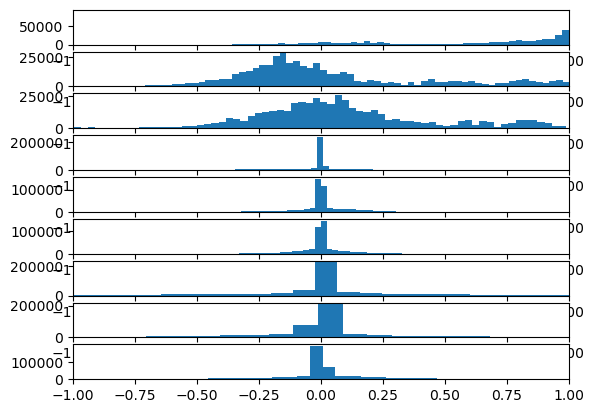

In [70]:
# load data
trainX, trainy, testX, testy = load_dataset()
# plot histograms
plot_variable_distributions(trainX)

In [71]:
# standardize data
def scale_data(trainX, testX, standardize):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
 flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
 # standardize
 if standardize:
     s = StandardScaler()
     # fit on training data
     s.fit(longX)
     # apply to training and test data
     longX = s.transform(longX)
     flatTrainX = s.transform(flatTrainX)
     flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX.shape))
 flatTestX = flatTestX.reshape((testX.shape))
 return flatTrainX, flatTestX

In [72]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, param):
 verbose, epochs, batch_size = 0, 10, 32
 n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
 # scale data
 trainX, testX = scale_data(trainX, testX, param)
 model = Sequential()
 model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
 model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
 model.add(Dropout(0.5))
 model.add(MaxPooling1D(pool_size=2))
 model.add(Flatten())
 model.add(Dense(100, activation='relu'))
 model.add(Dense(n_outputs, activation='softmax'))
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
 return accuracy

In [81]:
# summarize scores
def summarize_results(scores, params):
 print(scores, params)
 # summarize mean and standard deviation
 for i in range(len(scores)):
     m, s = mean(scores[i]), std(scores[i])
     print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
 # boxplot of scores
 pyplot.boxplot(scores, labels=params)
 #pyplot.savefig('exp_cnn_standardize.png')

In [82]:
# run an experiment
def run_experiment(params, repeats=10):
 # load data
 trainX, trainy, testX, testy = load_dataset()
 # test each parameter
 all_scores = list()
 for p in params:
 # repeat experiment
    scores = list()
    for r in range(repeats):
         score = evaluate_model(trainX, trainy, testX, testy, p)
         score = score * 100.0
         print('>p=%s #%d: %.3f' % (p, r+1, score))
         scores.append(score)
    all_scores.append(scores)
 # summarize results
 summarize_results(all_scores, params)

load_dataset append_before = 
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
---------before(y)----------
(7352, 1)
---------after(y)-----------
(7352, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=False #1: 90.024
>p=False #2: 90.804
>p=False #3: 90.906
>p=False #4: 90.159
>p=False #5: 91.890
>p=False #6: 91.042
>p=False #7: 89.922
>p=False #8: 91.958
>p=False #9: 91.483
>p=False #10: 89.786
>p=True #1: 92.094
>p=True #2: 92.263
>p=True #3: 91.211
>p=True #4: 91.449
>p=True #5: 91.042
>p=True #6: 87.106
>p=True #7: 91.110
>p=True #8: 89.922
>p=True #9: 87.852
>p=True #10: 91.449
[[90.0237500667572, 90.80420732498169, 90.90600609779358, 90.15948176383972, 91.89005494117737, 91.0417377948761, 89.92195725440979, 91.95792078971863, 91.48286581039429, 89.78622555732727], [92.09365248680115, 92.2633171081543, 91.21140241622925, 91.44893288612366, 91.0417377948761, 87.10553050041199, 91.10960364341736, 89.92195725440979, 87.85205483436584, 91.44893288612366]] [False, True]
Param

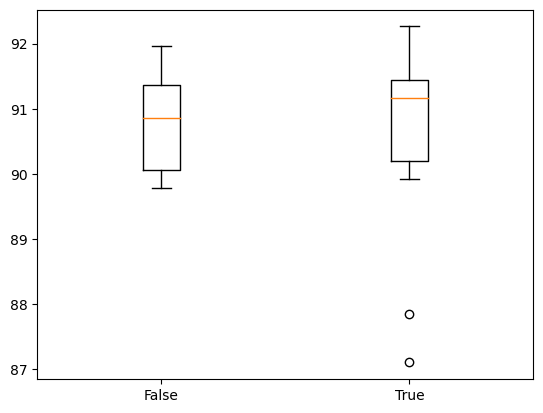

In [83]:
# run the experiment
n_params = [False, True]
run_experiment(n_params)

# Number of Filters

In [9]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_filters):
 verbose, epochs, batch_size = 0, 10, 32
 n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
 model = Sequential()
 model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
 model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
 model.add(Dropout(0.5))
 model.add(MaxPooling1D(pool_size=2))
 model.add(Flatten())
 model.add(Dense(100, activation='relu'))
 model.add(Dense(n_outputs, activation='softmax'))
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
 return accuracy

In [10]:
# summarize scores
def summarize_results(scores, params):
 print(scores, params)
 # summarize mean and standard deviation
 for i in range(len(scores)):
     m, s = mean(scores[i]), std(scores[i])
     print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
 # boxplot of scores
 pyplot.boxplot(scores, labels=params)
 #pyplot.savefig('exp_cnn_filters.png')

In [11]:
# run an experiment
def run_experiment(params, repeats=10):
 # load data
 trainX, trainy, testX, testy = load_dataset()
 # test each parameter
 all_scores = list()
 for p in params:
     # repeat experiment
     scores = list()
     for r in range(repeats):
         score = evaluate_model(trainX, trainy, testX, testy, p)
         score = score * 100.0
         print('>p=%d #%d: %.3f' % (p, r+1, score))
         scores.append(score)
     all_scores.append(scores)
 # summarize results
 summarize_results(all_scores, params)

load_dataset append_before = 
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
---------before(y)----------
(7352, 1)
---------after(y)-----------
(7352, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=8 #1: 89.515
>p=8 #2: 89.922
>p=8 #3: 90.363
>p=8 #4: 88.768
>p=8 #5: 88.633
>p=8 #6: 90.193
>p=8 #7: 87.750
>p=8 #8: 89.413
>p=8 #9: 88.938
>p=8 #10: 88.734
>p=16 #1: 89.413
>p=16 #2: 90.295
>p=16 #3: 90.431
>p=16 #4: 91.211
>p=16 #5: 87.886
>p=16 #6: 89.718
>p=16 #7: 90.465
>p=16 #8: 88.633
>p=16 #9: 89.956
>p=16 #10: 90.058
>p=32 #1: 90.567
>p=32 #2: 91.483
>p=32 #3: 90.635
>p=32 #4: 89.583
>p=32 #5: 90.024
>p=32 #6: 89.006
>p=32 #7: 89.209
>p=32 #8: 90.872
>p=32 #9: 89.379
>p=32 #10: 89.447
>p=64 #1: 90.024
>p=64 #2: 90.465
>p=64 #3: 91.686
>p=64 #4: 89.345
>p=64 #5: 92.060
>p=64 #6: 89.413
>p=64 #7: 90.872
>p=64 #8: 88.972
>p=64 #9: 90.702
>p=64 #10: 89.752
>p=128 #1: 90.770
>p=128 #2: 89.006
>p=128 #3: 90.092
>p=128 #4: 90.193
>p=128 #5: 89.820
>p=128 #6: 90.872
>p=128 #7:

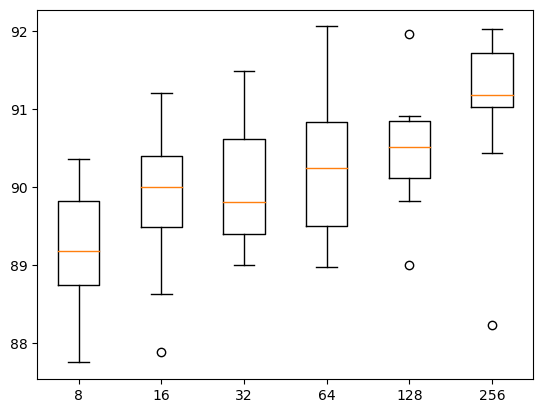

In [12]:
# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)

# Size of kernel

In [85]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_kernel):
 verbose, epochs, batch_size = 0, 15, 32
 n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
 model = Sequential()
 model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps,n_features)))
 model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu'))
 model.add(Dropout(0.5))
 model.add(MaxPooling1D(pool_size=2))
 model.add(Flatten())
 model.add(Dense(100, activation='relu'))
 model.add(Dense(n_outputs, activation='softmax'))
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
 return accuracy

In [86]:
# summarize scores
def summarize_results(scores, params):
 print(scores, params)
 # summarize mean and standard deviation
 for i in range(len(scores)):
     m, s = mean(scores[i]), std(scores[i])
     print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
 # boxplot of scores
 pyplot.boxplot(scores, labels=params)
 #pyplot.savefig('exp_cnn_kernel.png')

In [87]:
# run an experiment
def run_experiment(params, repeats=10):
 # load data
 trainX, trainy, testX, testy = load_dataset()
 # test each parameter
 all_scores = list()
 for p in params:
 # repeat experiment
     scores = list()
     for r in range(repeats):
         score = evaluate_model(trainX, trainy, testX, testy, p)
         score = score * 100.0
         print('>p=%d #%d: %.3f' % (p, r+1, score))
         scores.append(score)
     all_scores.append(scores)
 # summarize results
 summarize_results(all_scores, params)

load_dataset append_before = 
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
---------before(y)----------
(7352, 1)
---------after(y)-----------
(7352, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=2 #1: 89.583
>p=2 #2: 91.076
>p=2 #3: 89.311
>p=2 #4: 89.345
>p=2 #5: 90.872
>p=2 #6: 89.990
>p=2 #7: 90.601
>p=2 #8: 88.700
>p=2 #9: 90.974
>p=2 #10: 87.106
>p=3 #1: 89.515
>p=3 #2: 88.565
>p=3 #3: 90.363
>p=3 #4: 90.872
>p=3 #5: 91.245
>p=3 #6: 90.058
>p=3 #7: 89.956
>p=3 #8: 91.144
>p=3 #9: 89.379
>p=3 #10: 89.718
>p=5 #1: 92.094
>p=5 #2: 92.060
>p=5 #3: 92.603
>p=5 #4: 91.686
>p=5 #5: 91.245
>p=5 #6: 90.295
>p=5 #7: 90.940
>p=5 #8: 91.890
>p=5 #9: 91.720
>p=5 #10: 91.381
>p=7 #1: 90.668
>p=7 #2: 91.653
>p=7 #3: 91.415
>p=7 #4: 90.974
>p=7 #5: 92.094
>p=7 #6: 91.619
>p=7 #7: 89.854
>p=7 #8: 92.501
>p=7 #9: 93.213
>p=7 #10: 91.245
>p=11 #1: 92.263
>p=11 #2: 91.992
>p=11 #3: 90.940
>p=11 #4: 94.774
>p=11 #5: 89.820
>p=11 #6: 89.243
>p=11 #7: 92.501
>p=11 #8: 91.008
>p=11 #9: 93

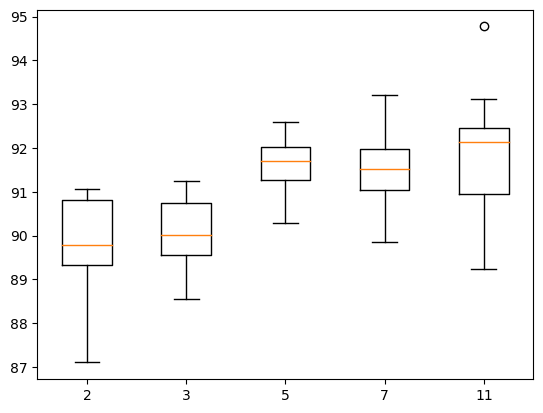

In [88]:
# run the experiment
n_params = [2, 3, 5, 7, 11]
run_experiment(n_params)

# Multi-Headed Convolutional Neural Network

In [6]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
 verbose, epochs, batch_size = 0, 10, 32
 n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
 # head 1
 inputs1 = Input(shape=(n_timesteps,n_features))
 conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
 drop1 = Dropout(0.5)(conv1)
 pool1 = MaxPooling1D(pool_size=2)(drop1)
 flat1 = Flatten()(pool1)
 # head 2
 inputs2 = Input(shape=(n_timesteps,n_features))
 conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
 drop2 = Dropout(0.5)(conv2)
 pool2 = MaxPooling1D(pool_size=2)(drop2)
 flat2 = Flatten()(pool2)
 # head 3
 inputs3 = Input(shape=(n_timesteps,n_features))
 conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
 drop3 = Dropout(0.5)(conv3)
 pool3 = MaxPooling1D(pool_size=2)(drop3)
 flat3 = Flatten()(pool3)
 # merge
 merged = concatenate([flat1, flat2, flat3])
 # interpretation
 dense1 = Dense(100, activation='relu')(merged)
 outputs = Dense(n_outputs, activation='softmax')(dense1)
 model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
 # save a plot of the model
 #plot_model(model, show_shapes=True, to_file='multichannel.png')
 plot_model(model, show_shapes=True)
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
 return accuracy

In [7]:
# summarize scores
def summarize_results(scores):
 print(scores)
 m, s = mean(scores), std(scores)
 print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [8]:
# run an experiment
def run_experiment(repeats=10):
 # load data
 trainX, trainy, testX, testy = load_dataset()
 # repeat experiment
 scores = list()
 for r in range(repeats):
     score = evaluate_model(trainX, trainy, testX, testy)
     score = score * 100.0
     print('>#%d: %.3f' % (r+1, score))
     scores.append(score)
 # summarize results
 summarize_results(scores)

In [9]:
# run the experiment
run_experiment()

load_dataset append_before = 
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
---------before(y)----------
(7352, 1)
---------after(y)-----------
(7352, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 91.517
>#2: 92.637
>#3: 92.162
>#4: 92.162
>#5: 91.211
>#6: 91.653
>#7: 92.976
>#8: 90.770
>#9: 92.874
>#10: 92.501
[91.51679873466492, 92.63657927513123, 92.16151833534241, 92.16151833534241, 91.21140241622925, 91.65253043174744, 92.97590851783752, 90.77027440071106, 92.87410974502563, 92.5008475780487]
Accuracy: 92.046% (+/-0.699)


In [9]:
trainX, trainy, testX, testy = load_dataset()

load_dataset append_before = 
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
---------before(y)----------
(7352, 1)
---------after(y)-----------
(7352, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [15]:
filenames = list()
 # total acceleration
group = 'train'
filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
 # body acceleration
filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
 # body gyroscope
filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
prefix = 'HARDataset/train/Inertial Signals/'
loaded = list()
for name in filenames:
    data = load_file(prefix + name)
    loaded.append(data)
    np.array(loaded)
     # stack group so that features are the 3rd dimension

In [16]:
loaded1 = np.array(loaded)
loaded1.shape

(9, 7352, 128)

In [17]:
#loaded는 9, 128개씩 7352개의 데이터

In [18]:
loaded[4][0]

array([ 1.076681e-02,  6.579480e-03,  8.928878e-03,  7.488683e-03,
        6.140966e-03,  6.944317e-03,  3.552423e-03,  2.537128e-03,
        4.084532e-03,  5.118448e-03,  5.892268e-03,  7.249871e-03,
        9.790774e-03,  7.661138e-03,  5.189360e-03,  6.823079e-03,
        5.606931e-03,  4.729647e-03,  4.183207e-03,  7.066339e-04,
       -4.544368e-04, -2.410674e-04, -5.438688e-04, -9.499844e-04,
       -1.421207e-03, -1.361999e-03, -2.328840e-03, -3.931010e-03,
       -4.676219e-03, -1.352050e-03,  2.857771e-03, -8.045508e-04,
       -5.447914e-03, -4.810002e-03, -4.869238e-03, -4.080336e-03,
       -6.791119e-04,  1.696425e-03,  2.687273e-03,  3.054424e-03,
        3.114898e-03,  2.052629e-03,  1.515292e-03,  2.070830e-03,
       -6.266231e-04, -4.514772e-03, -5.925923e-03, -5.062805e-03,
       -2.244477e-03, -7.860878e-04, -1.218282e-03, -1.676407e-03,
       -2.273432e-03, -4.803613e-03, -8.823154e-03, -8.774635e-03,
       -7.305396e-03, -8.229220e-03, -8.141506e-03, -7.250328e